In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge


In [26]:
import pandas as pd  # 导入 pandas 库


In [27]:
from scipy.special import j1
from scipy.signal import find_peaks


In [28]:
# 定义物理参数
c = 1500  # 声速，单位：m/s
rho0 = 1000  # 介质密度，单位：kg/m^3
f = 4e6  # 频率，单位：Hz
k = 2 * np.pi * f / c  # 波数
w = 2 * np.pi * f  # 角频率
u = 1  # 质点振动速度
lambda_ = c / f  # 波长

In [29]:
# 定义环形相控阵参数
m = 6  # 圆环个数
R_max = 7.78e-3  # 中心阵元到最大辐射圆环中心的距离，单位：m
F = 10e-3  # 聚焦焦距，单位：m
Nmax = 15e-3 # 近场临界距离
n = 0.7 #(m - 1) / m  # 圆环间距与波长的倍数系数
delta_d = n * lambda_  # 圆环之间的间距
# 定义 theta 范围
rmin = np.sqrt(Nmax*lambda_)
# 固定 r、phi 和 t 的值
r = F  # 可根据需要调整 r 的值
phi = 0
t = 0

In [30]:
all_data = []  # 用于存储所有 m 值对应的圆环阵列数据
mainlobe_avg_list = []
sidelobe_avg_list = []
Ri_list = np.zeros(m)
Ro_list = np.zeros(m)
a1_list = []  # 存储每个圆环的a1值
a2_list = []  # 存储每个圆环的a2值
theta_values = np.linspace(-np.pi/2 , np.pi /2, 2000)

In [31]:
def save_annular_array_parameters(m,a1_list,a2_list):
    data = {
        'm值': [m] * m,  # 添加 m 值列
        '环编号': [i + 1 for i in range(m)],
        '内径 (mm)': [f'{a1*1000:.6f}' for a1 in a1_list],
        '外径 (mm)': [f'{a2*1000:.6f}' for a2 in a2_list]
    }
    df = pd.DataFrame(data)
    all_data.append(df)

    # 合并所有 DataFrame
    combined_df = pd.concat(all_data, ignore_index=True)

    # 保存到同一个 CSV 文件
    csv_file_path = 'annular_array_parameters_all.csv'
    combined_df.to_csv(csv_file_path, index=False)
    #print(f"所有 m 值对应的圆环阵列参数已保存到 {csv_file_path}")


In [32]:
# 封装计算等面积圆环内外径的代码为函数
def calculate_annular_radii(R_max, m, n):
    a1_list = []  # 存储每个圆环的a1值
    a2_list = []  # 存储每个圆环的a2值
    # 定义环形相控阵参数
    delta_d = n * lambda_  # 圆环之间的间距    
    total_area = np.pi * R_max ** 2
    ring_area = (total_area-(m-1)*2*np.pi*R_max/2*delta_d) / m
    for i in range(m):
        if i == 0:
            a1 = 0
        else:
            a1 = a2_list[i - 1] + delta_d
        a2 = np.sqrt(a1 ** 2 + ring_area / np.pi)
        a2_list.append(a2)
        a1_list.append(a1)
    save_annular_array_parameters(m, a1_list, a2_list)
    return a1_list, a2_list

In [33]:
# 定义颜色列表
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

In [34]:
# 封装绘制圆环阵列的代码为函数
def plot_annular_array(inner_radii, outer_radii, colors):
    fig, ax = plt.subplots()
    for i, (a1, a2) in enumerate(zip(inner_radii, outer_radii)):
        # 使用 Wedge 绘制中间有填充的环形
        ring = Wedge((0, 0), a2, 0, 360, width=(a2 - a1))
        # 从颜色列表中选取颜色进行填充
        color = colors[i % len(colors)]
        ring.set_facecolor(color)
        ring.set_edgecolor(color)
        ax.add_artist(ring)

        # 计算圆环面积
        area = np.pi * (a2**2 - a1**2)*1e6
        # 确定标注位置（圆环中心角度位置）
        label_r = (a1 + a2) / 2
        label_theta = 45  # 角度可以根据需要调整
        label_x = label_r * np.cos(np.radians(label_theta))
        label_y = label_r * np.sin(np.radians(label_theta))
        # 显示面积标注
        ax.text(label_x, label_y, f'area:{area:.2f}mm2', ha='left', va='center', color='black', fontsize=6)

    ax.set_xlim(-a1  * 1.5, a2  * 1.5)
    ax.set_ylim(-a1  * 1.5, a2  * 1.5)
    ax.set_aspect('equal')
    ax.set_title('Annular Array')
    plt.show()

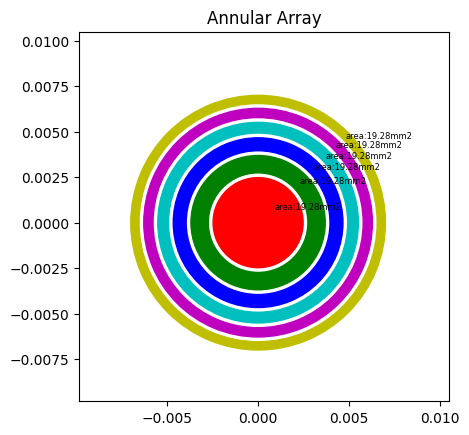

,Ri(mm),Ro(mm)
0,0.000000,2.477401
1,2.739901,3.693856
2,3.956356,4.668005
3,4.930505,5.517916
4,5.780416,6.288937
5,6.551437,7.004202


In [35]:
R_max = 6.76e-3
m = 6
n = 0.7
NFmax = 16e-3
F = 20e-3
r = F

Ri_list, Ro_list = calculate_annular_radii(R_max,m,n)
# 调用函数绘制圆环阵列
plot_annular_array(Ri_list, Ro_list, colors)
R_list = np.column_stack((Ri_list,Ro_list))
# 将R_list转换为pandas DataFrame

R_df = pd.DataFrame(R_list*1e3, columns=['Ri(mm)', 'Ro(mm)'])

# 打印DataFrame
R_df

In [36]:
# 定义声压公式，考虑分母为 0 的情况
def annular_array_pressure(a1_list,a2_list, F, r, m, theta, phi, t):
    p_total = 0
    epsilon = 1e-20  # 一个极小值，用于避免分母为 0
    Rm_max = 2/3*(a2_list[m-1]**3 - a2_list[m-2]**3)/(a2_list[m-1]**2-a2_list[m-2]**2)
    for i in range(m):
        a1 = a1_list[i]
        a2 = a2_list[i]
        R_m = 2/3*(a2**3 - a1**3)/(a2**2-a1**2)
        
        t_m = (np.sqrt(Rm_max ** 2 + F ** 2) - F - (np.sqrt(R_m ** 2 + F ** 2) - F)) / c
        denominator1 = k * a2 * np.cos(phi) * np.sin(theta)
        denominator2 = k * a1 * np.cos(phi) * np.sin(theta)

        # 计算 term1
        if np.abs(denominator1) < epsilon:
            # 当分母接近 0 时，使用贝塞尔函数极限性质
            term1 = a2 / 2
        else:
            term1 = (a2 ** 2 * j1(k * a2 * np.cos(phi) * np.sin(theta))) / denominator1

        # 计算 term2
        if np.abs(denominator2) < epsilon:
            # 当分母接近 0 时，使用贝塞尔函数极限性质
            term2 = a1 / 2
        else:
            term2 = (a1 ** 2 * j1(k * a1 * np.cos(phi) * np.sin(theta))) / denominator2

        p = (1j * k * rho0 * c * u / r) * (term1 - term2) * np.exp(1j * (w * t_m - k * r))
        p_total += p      
                        
    return p_total

In [37]:
# 计算单个圆环的声压
# 定义声压公式，考虑分母为 0 的情况
def annular_array_pressure_axis_delay(a1_list,a2_list, m, index, F, r, t, tdelay):
    p_total = 0    
    # print("Rm_max: ", Rm_max)
    if index > m:
        print("index big!")
    else:
            a1 = a1_list[index]
            a2 = a2_list[index]
                    
            #print("delay_temp: ", delay_temp)
            t1 = np.sqrt(a1 ** 2 + r ** 2) 
            t2 = np.sqrt(a2 ** 2 + r ** 2)
            
            p = (rho0 * c* u) * np.exp(1j * w * t)* np.exp(-1j * w * tdelay)* (np.exp(-1j * k * t1) - np.exp(-1j * k * t2) )
            p_total += p

    NFmax = (a2**2-a1**2)/lambda_
    #print("index: %d"%index,"a1: %.3f"%a1,"a2: %.3f"%a2,"NF: %.3fmm"%(NFmax*1e3))
    return p_total

In [38]:

def annular_array_pressure_axis(a1_list,a2_list, m, F, r, t):
    p_total = 0
    
    Rm_max = 2/3*(a2_list[m-1]**3 - a2_list[m-2]**3)/(a2_list[m-1]**2-a2_list[m-2]**2)
    # print("Rm_max: ", Rm_max)
    
    for i in range(m):
        a1 = a1_list[i]
        a2 = a2_list[i]
        R_m = 2/3*(a2**3 - a1**3)/(a2**2-a1**2)

        t_m = np.sqrt(Rm_max ** 2 + F ** 2) - np.sqrt(R_m ** 2 + F ** 2)
        t1 = np.sqrt(a1 ** 2 + r ** 2) 
        t2 = np.sqrt(a2 ** 2 + r ** 2)
        
        p = (rho0 * c* u) * np.exp(1j * w * t)* np.exp(-1j * k * t_m)* (np.exp(-1j * k * t1) - np.exp(-1j * k * t2) )
        p_total += p
            
    NFmax = (a2**2-a1**2)/lambda_
    #print("index: %d"%index,"a1: %.3f"%a1,"a2: %.3f"%a2,"NF: %.3fmm"%(NFmax*1e3))
    return p_total

In [39]:
# 定义评价声压旁瓣和主瓣的平均函数
def evaluate_sidelobe_mainlobe(pressure_values):
    # 找到最大声压值及其索引
    num = len(pressure_values)
    max_pressure = max(pressure_values)
    max_index = pressure_values.index(max_pressure)
    # print("Mid num:",num/2, "max index:",max_index)

    if max_index < num / 2:
        max_index = int(num / 2)

    # 简单假设主瓣是最大声压值左右各 5 个点的范围，可根据实际情况调整
    mainlobe_start = max(0, max_index - 5)
    mainlobe_end = min(len(pressure_values), max_index + 5)

    # 计算主瓣的平均声压
    mainlobe_pressures = pressure_values[mainlobe_start:mainlobe_end]
    mainlobe_avg = np.mean(mainlobe_pressures)

    # 找出所有峰值点
    peaks = []
    for i in range(1, len(pressure_values) - 1):
        if pressure_values[i] > pressure_values[i - 1] and pressure_values[i] > pressure_values[i + 1]:
            peaks.append(pressure_values[i])

    # 排除主瓣范围内的峰值
    sidelobe_peaks = []
    for peak in peaks:
        peak_index = pressure_values.index(peak)
        if peak_index < mainlobe_start or peak_index >= mainlobe_end:
            sidelobe_peaks.append(peak)

    # 计算旁瓣平均声压
    sidelobe_avg = np.mean(sidelobe_peaks) if sidelobe_peaks else 0


    return mainlobe_avg, sidelobe_avg

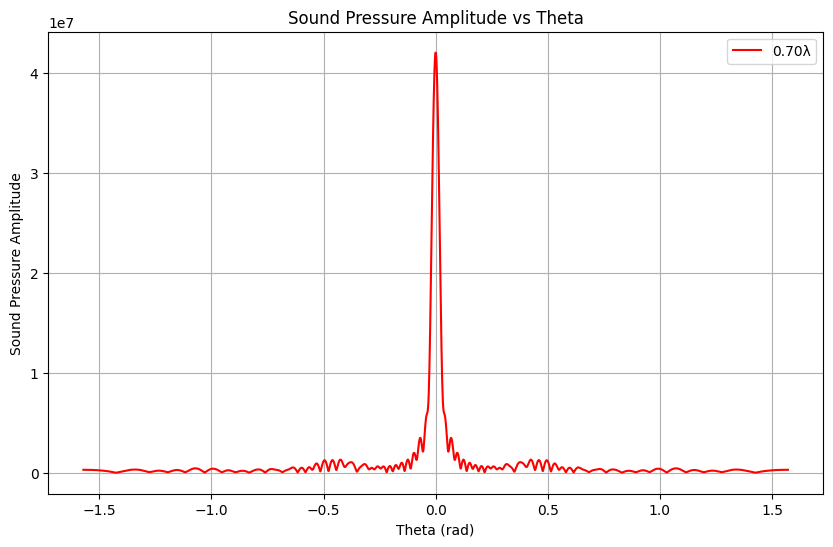

主瓣平均声压: 40678764.782602
旁瓣平均声压: 816410.601393


In [40]:
plt.figure(figsize=(10, 6))   

R_max = 6.76e-3
m = 6
n = 0.7
NFmax = 16e-3
F = 10e-3
r = F

# 计算每个 theta 对应的声压幅值
pressure_values = []
for theta in theta_values:
    pressure = annular_array_pressure(Ri_list, Ro_list,  F, r, m, theta, phi, t)
    pressure_amplitude = np.abs(pressure)
    pressure_values.append(pressure_amplitude)
    # 绘制声压随 theta 的变化曲线    
plt.plot(theta_values, pressure_values,label='%.2fλ'%n,color='red')
plt.xlabel('Theta (rad)')
plt.ylabel('Sound Pressure Amplitude')
plt.title('Sound Pressure Amplitude vs Theta')
plt.legend()
plt.grid(True)
plt.show()    

# 调用评价函数
mainlobe_avg, sidelobe_avg = evaluate_sidelobe_mainlobe(pressure_values)
print(f"主瓣平均声压: {mainlobe_avg:.6f}")
print(f"旁瓣平均声压: {sidelobe_avg:.6f}")

In [41]:
def Sound_Pressure_delta(m, F, r, R_max, n, theta, phi, t):
    # 定义 theta 范围
    theta_values = np.linspace(-np.pi/2 , np.pi /2, 1000)

    # 定义 delta_d 数组，范围从 0.1 * lambda_ 到 2 * lambda_
    delta_d_array = np.linspace(0.4 * lambda_, 1 * lambda_, 5)
    
    Rin_list = np.zeros(m)
    Rout_list = np.zeros(m)
    mainlobe_avg_list = []
    sidelobe_avg_list = []

    # 开始绘制不同 delta_d 下的声压曲线
    plt.figure(figsize=(20, 6))
    # 设置图片清晰度
    plt.rcParams['figure.dpi'] = 100

    for del_d in delta_d_array:
        # 调用函数计算圆环内外径
        Rin_list, Rout_list = calculate_annular_radii(R_max, m, n)
        # 调用函数绘制圆环阵列
        # plot_annular_array(Rin_list, Rout_list, R_max, delta_d, colors)
        # 计算每个 theta 对应的声压幅值
        pressure_values = []
        for the_ta in theta_values:
            pressure = annular_array_pressure(Rin_list,Rout_list,m, F, r, the_ta, phi, t)
            pressure_amplitude = np.abs(pressure)
            pressure_values.append(pressure_amplitude)
        # 将 theta 从弧度转换为角度
        theta_values_deg = np.rad2deg(theta_values)
        # 绘制声压随 theta（角度）的变化曲线
        plt.plot(theta_values_deg, pressure_values, label='{:.2f}λ'.format(del_d/lambda_))
        # 调用评价函数
        mainlobe_avg, sidelobe_avg = evaluate_sidelobe_mainlobe(pressure_values)
        mainlobe_avg_list.append(mainlobe_avg)
        sidelobe_avg_list.append(sidelobe_avg)
        #print(f"主瓣平均声压: {mainlobe_avg:.6f}")
        #print(f"旁瓣平均声压: {sidelobe_avg:.6f}")
            # 显示面积标注
    plt.xlabel('Theta (rad)')
    plt.ylabel('Sound Pressure Amplitude')
    plt.title('Sound Pressure Amplitude vs Theta')
    plt.legend()
    plt.grid(True)
    plt.show() 

""" 
    # 绘制主瓣平均声压柱状图
    x_pos = np.arange(len(delta_d_array))
    x_data = [f'{v:.3f}' for v in delta_d_array / lambda_]

    fig,ax1 = plt.subplots()
    fig.set_size_inches(20, 6)
    ax1.set_xticks(x_pos, x_data)

    ax1.plot(x_pos, mainlobe_avg_list,color='red')
    for i, v in enumerate(mainlobe_avg_list):
        ax1.text(x_pos[i], v, f'{v:.2e}', ha='center', va='bottom')
    ax1.set_xlabel('delta_d(λ)')
    ax1.set_ylabel('Mainlobe Average Sound Pressure')
    ax1.legend('Mainlobe')
    # plt.xlabel('delta_d')
    # plt.title('Mainlobe Average Sound Pressure')    
    # 显示图表
    # plt.show()
        
    # plt.figure(figsize=(20, 6))    
    # plt.xticks(x_pos, x_data)
    ax2 = ax1.twinx()
    ax2.plot(x_pos, sidelobe_avg_list,color='blue')
    ax2.set_ylabel('Sidelobe Average Sound Pressure')
    for i, v in enumerate(sidelobe_avg_list):
        ax2.text(x_pos[i], v, f'{v:.2e}', ha='center', va='bottom')
    ax2.legend('Sidelobe')    
    # plt.xlabel('delta_d')
    # plt.title('Sidelobe Average Sound Pressure')
    # 显示图表
    plt.show() """

" \n    # 绘制主瓣平均声压柱状图\n    x_pos = np.arange(len(delta_d_array))\n    x_data = [f'{v:.3f}' for v in delta_d_array / lambda_]\n\n    fig,ax1 = plt.subplots()\n    fig.set_size_inches(20, 6)\n    ax1.set_xticks(x_pos, x_data)\n\n    ax1.plot(x_pos, mainlobe_avg_list,color='red')\n    for i, v in enumerate(mainlobe_avg_list):\n        ax1.text(x_pos[i], v, f'{v:.2e}', ha='center', va='bottom')\n    ax1.set_xlabel('delta_d(λ)')\n    ax1.set_ylabel('Mainlobe Average Sound Pressure')\n    ax1.legend('Mainlobe')\n    # plt.xlabel('delta_d')\n    # plt.title('Mainlobe Average Sound Pressure')    \n    # 显示图表\n    # plt.show()\n        \n    # plt.figure(figsize=(20, 6))    \n    # plt.xticks(x_pos, x_data)\n    ax2 = ax1.twinx()\n    ax2.plot(x_pos, sidelobe_avg_list,color='blue')\n    ax2.set_ylabel('Sidelobe Average Sound Pressure')\n    for i, v in enumerate(sidelobe_avg_list):\n        ax2.text(x_pos[i], v, f'{v:.2e}', ha='center', va='bottom')\n    ax2.legend('Sidelobe')    \n    # plt.xl

In [42]:
def Sound_Pressure_single(m, F, r, R_max, n, theta, phi, t):
    
    Rin_list = np.zeros(m)
    Rout_list = np.zeros(m)
    
    # 调用函数计算圆环内外径
    Rin_list, Rout_list = calculate_annular_radii(R_max, m, n)
    # 调用函数绘制圆环阵列
    # plot_annular_array(Rin_list, Rout_list, colors)
    # 计算每个 theta 对应的声压幅值
    pressure_values = []
    theta_values = np.linspace(-np.pi/2 , np.pi /2, 2000)
    for the_ta in theta_values:
        pressure= annular_array_pressure(Rin_list,Rout_list, F, r, m, the_ta, phi, t)
        pressure_values.append(np.abs(pressure))
                
    return pressure_values

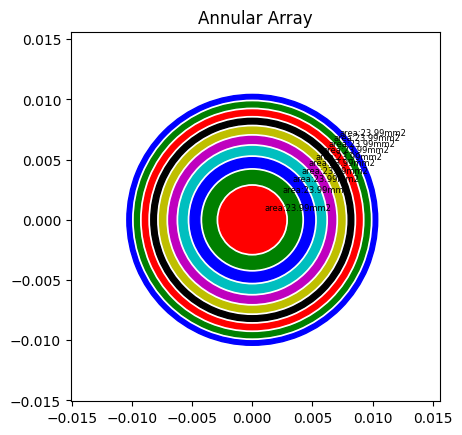

F(m):0.010 r(m):0.010205 Max=1.423e+07


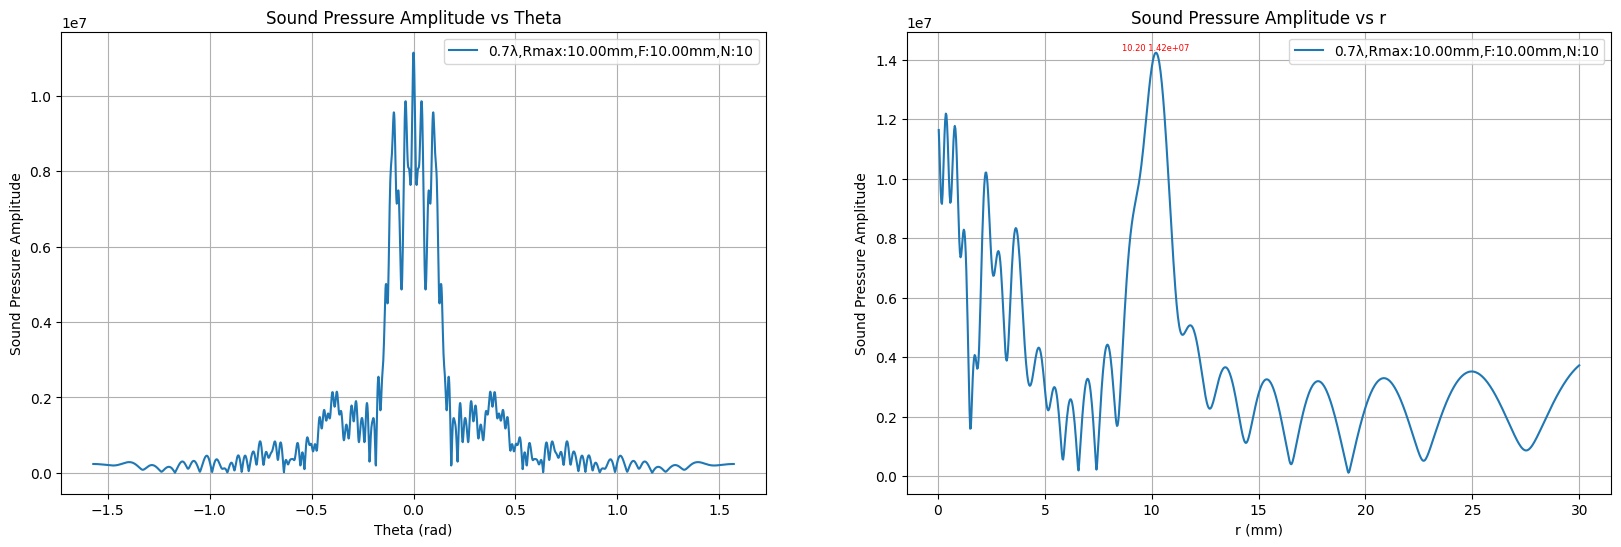

F(m):0.011 r(m):0.011105 Max=1.833e+07


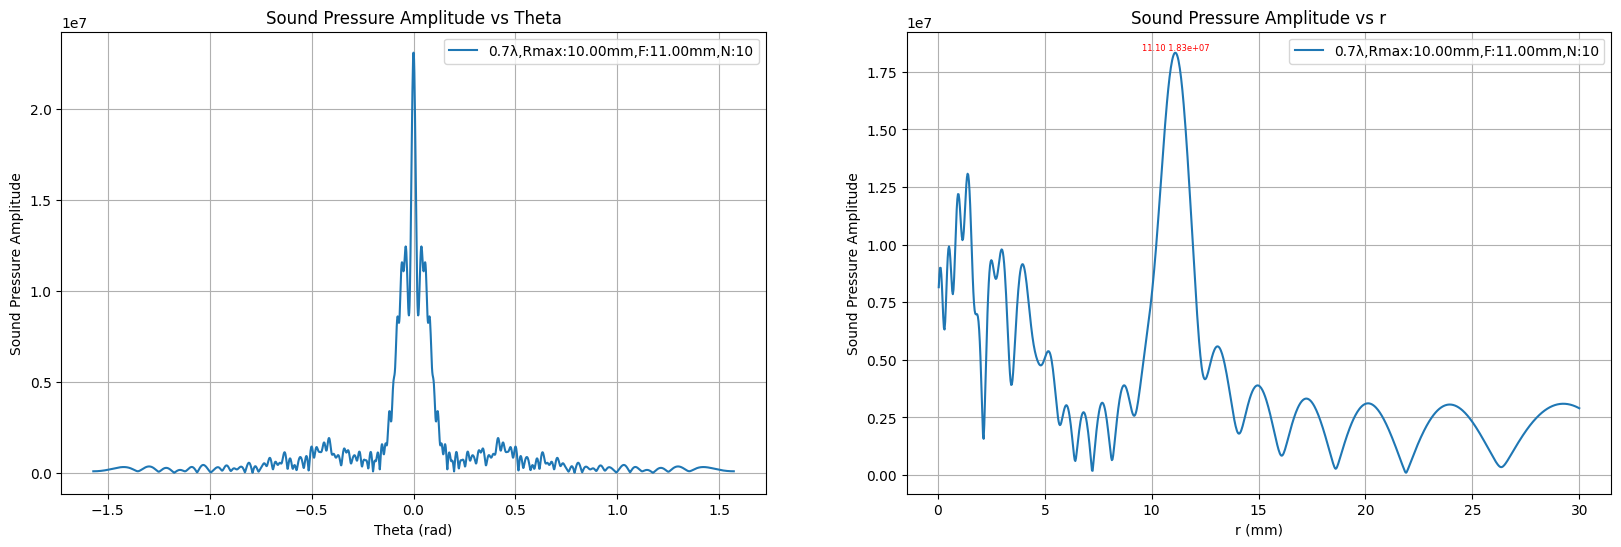

F(m):0.012 r(m):0.012064 Max=2.174e+07


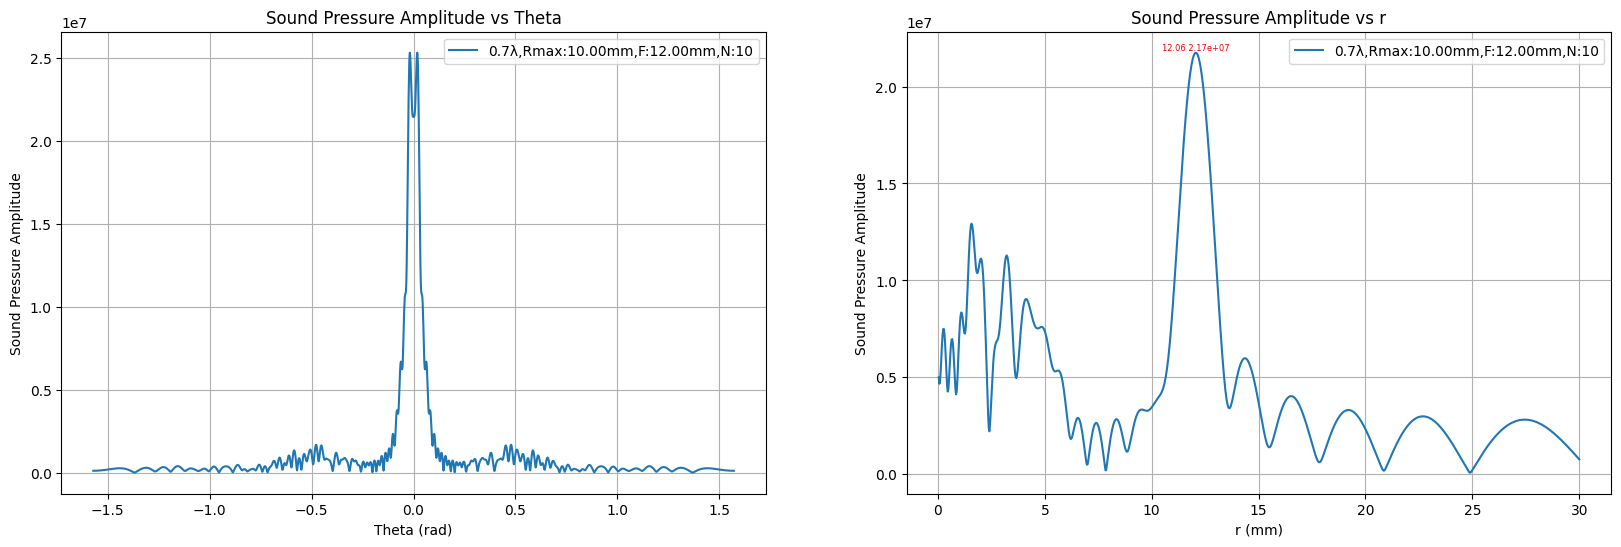

F(m):0.013 r(m):0.013054 Max=2.439e+07


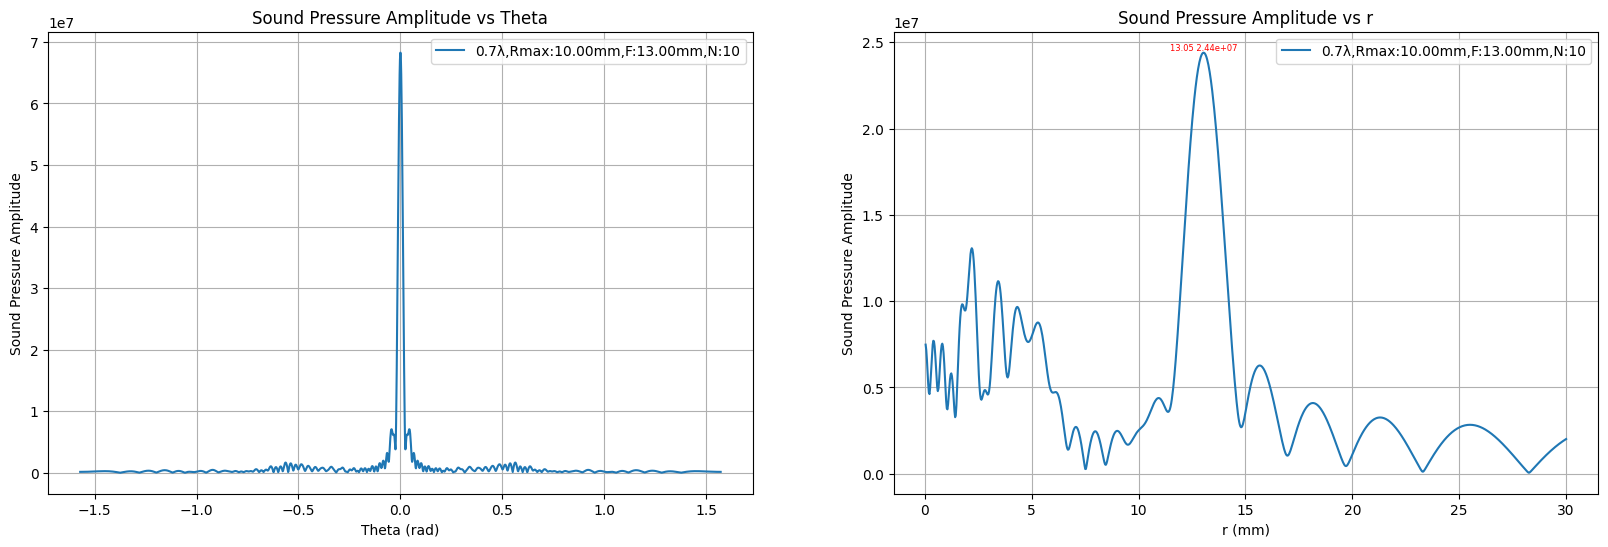

F(m):0.014 r(m):0.014014 Max=2.638e+07


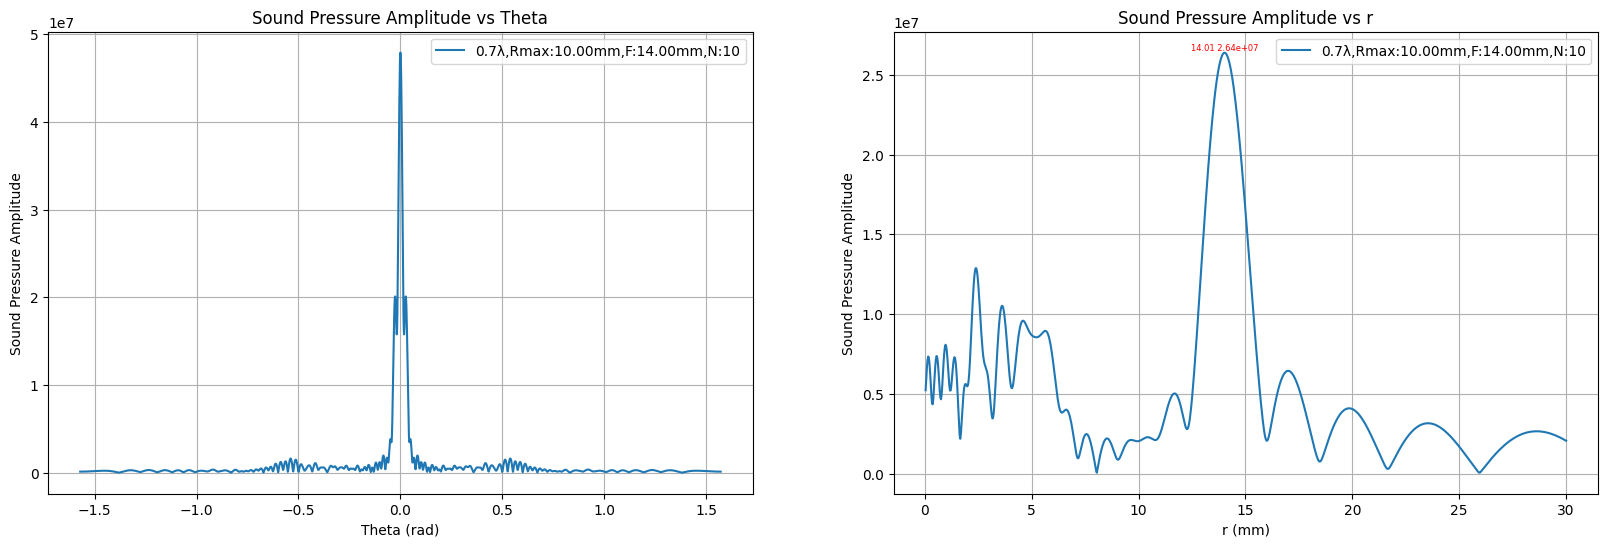

F(m):0.015 r(m):0.015004 Max=2.781e+07


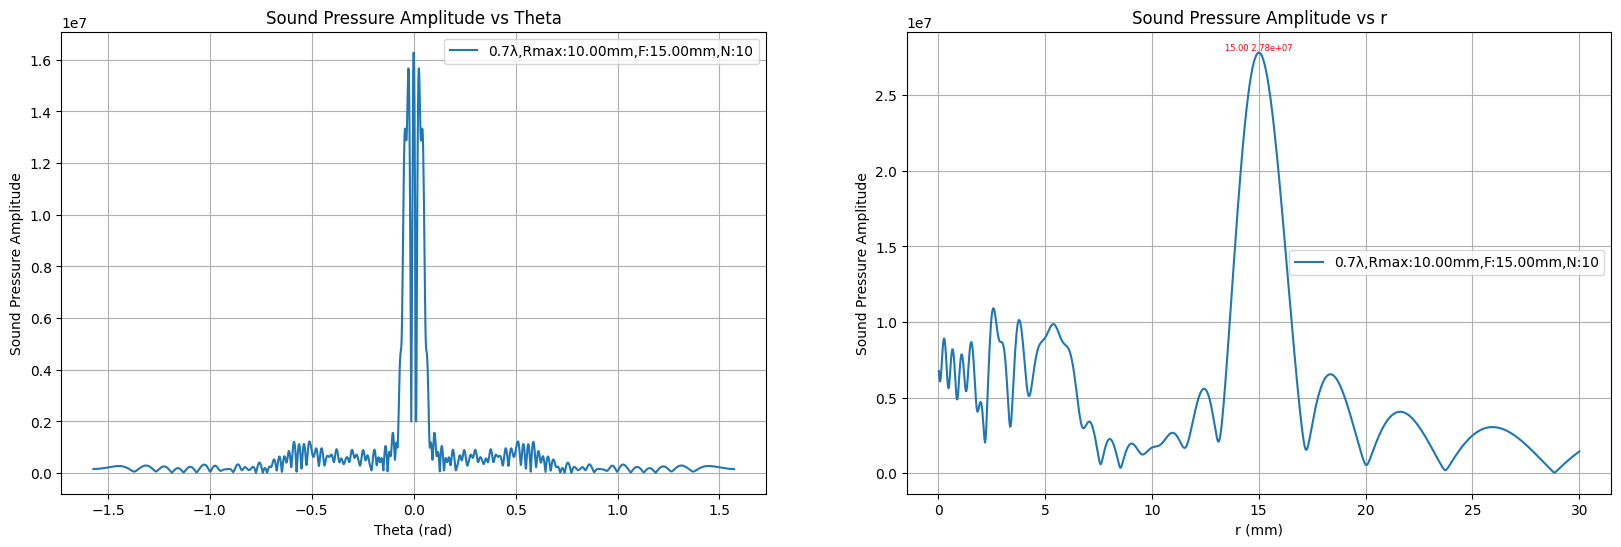

F(m):0.016 r(m):0.015994 Max=2.880e+07


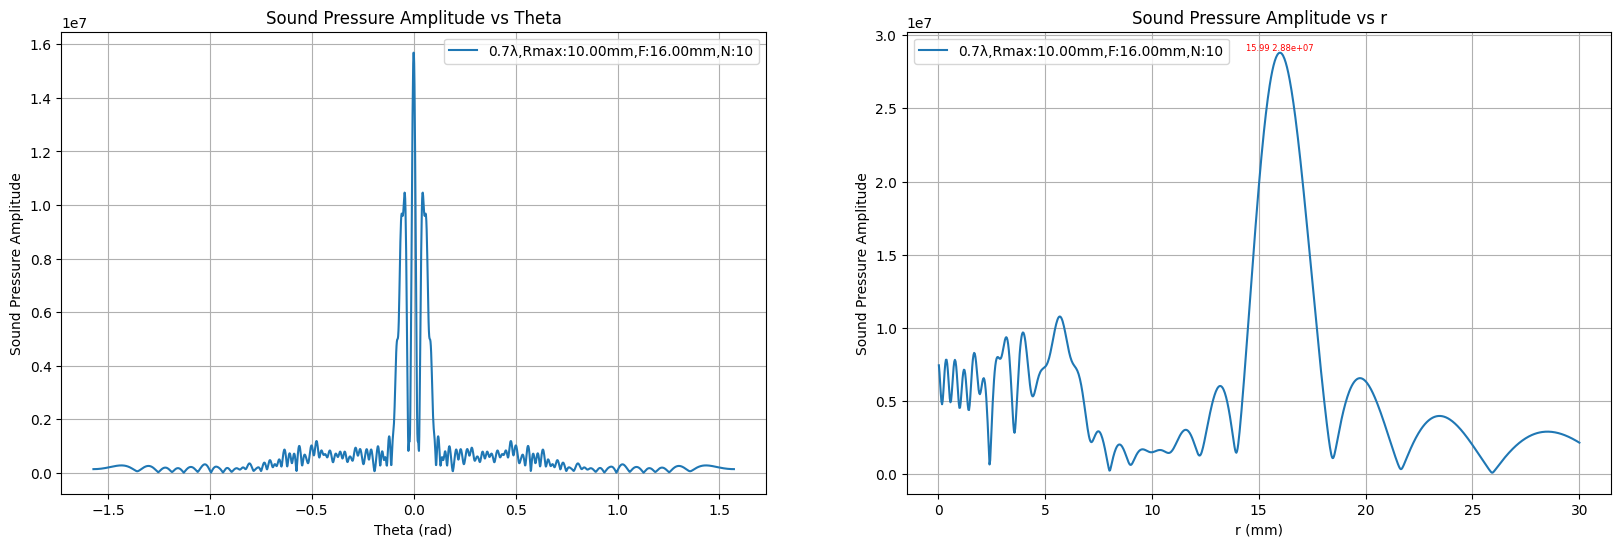

F(m):0.017 r(m):0.016983 Max=2.943e+07


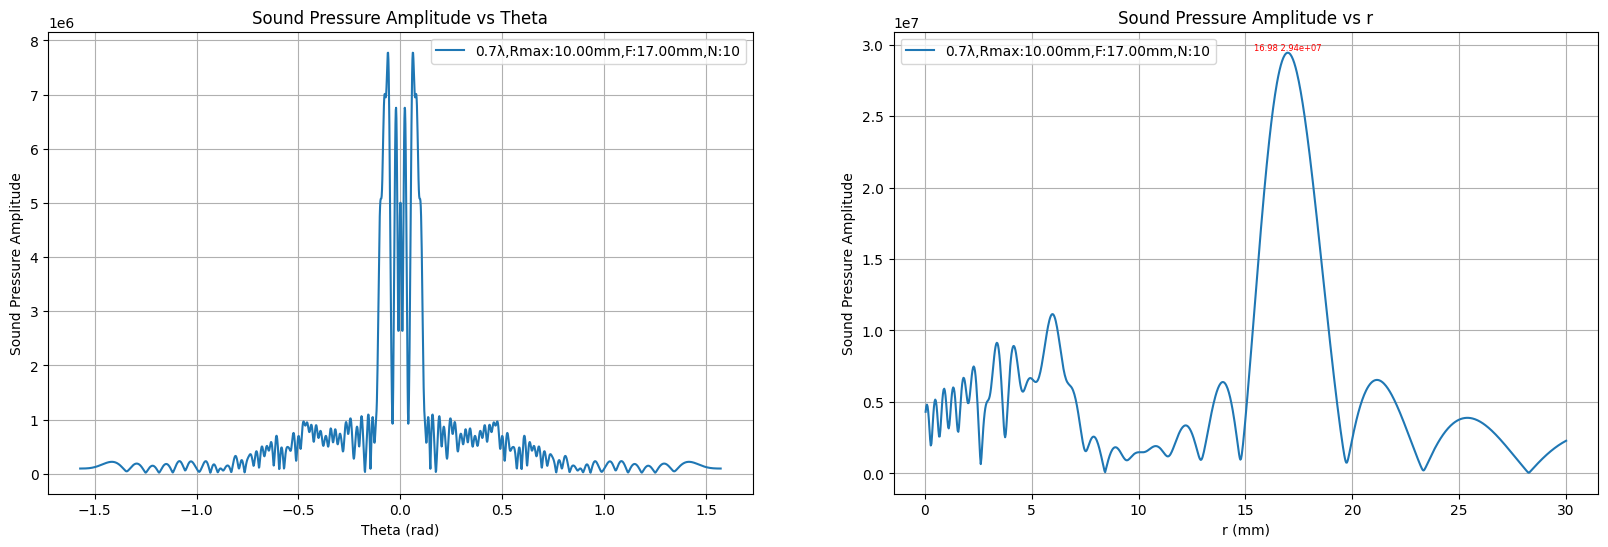

F(m):0.018 r(m):0.017973 Max=2.978e+07


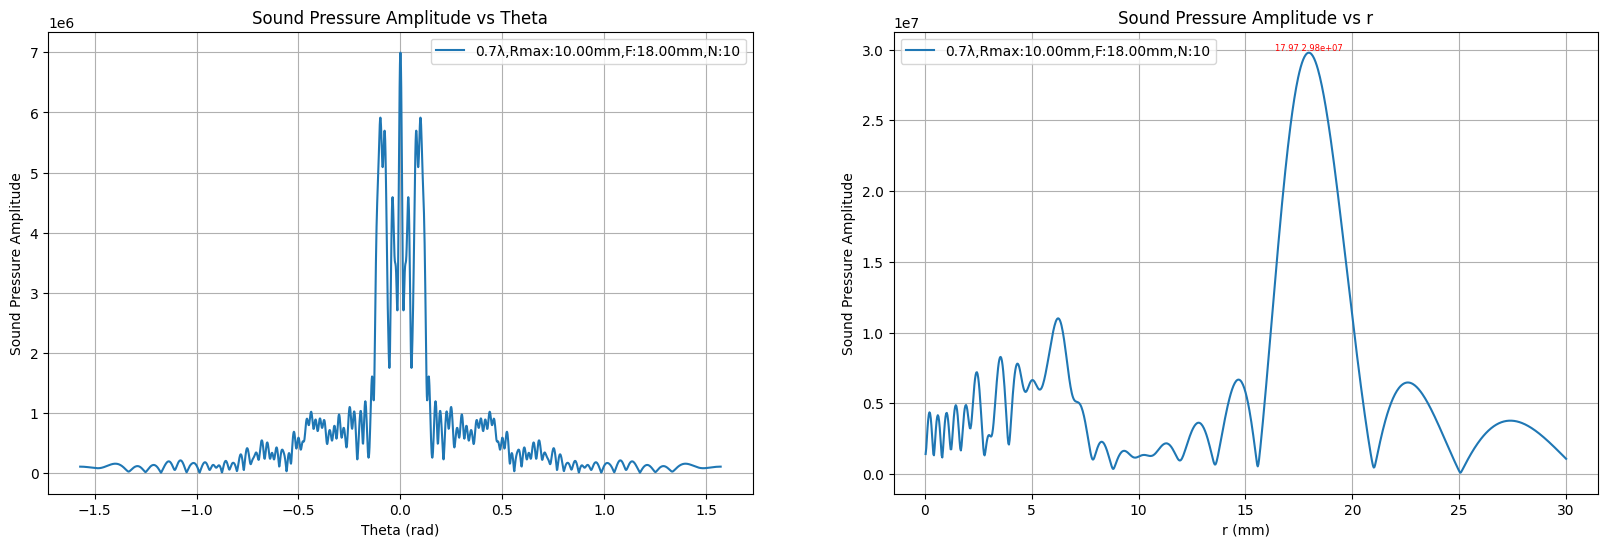

F(m):0.019 r(m):0.018963 Max=2.991e+07


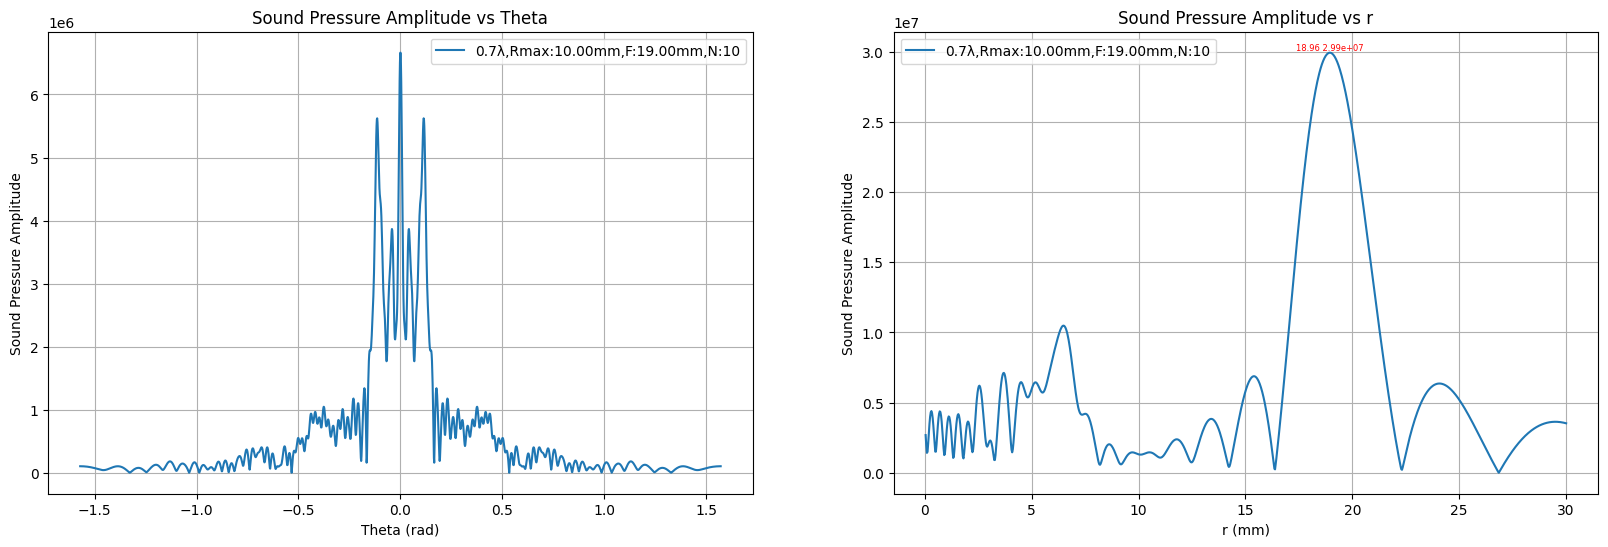

In [43]:
# 开始绘制不同 delta_d 下的声压曲线
# 设置图片清晰度
Fc = np.arange(10e-3,20e-3,1e-3)
rc = np.linspace(10e-3,20e-3,5)

Rm = 10e-3
ns = np.arange(10,11,1)

r_values = np.linspace(0.1*lambda_, F * 3,1000)  # 不同的距离 r 
pressure_amplitudes = []
Ri_list = np.zeros(ns[0])
Ro_list = np.zeros(ns[0])
Ri_list, Ro_list = calculate_annular_radii(R_max=Rm, m=ns[0], n=0.7)
# 调用函数绘制圆环阵列
plot_annular_array(Ri_list, Ro_list, colors)

for i in range(len(Fc)):


    plt.figure(figsize=(20, 6))
    #print('Fc = ',Fc[i],'rc = ',Fc[i],'Rm = ',Rm[j], 'ns = ', ns[0])
    pressure_val = Sound_Pressure_single(m=ns[0], F=Fc[i],r=Fc[i],R_max=Rm,n=0.7,theta=None,phi=0,t=0)
    plt.subplot(1, 2, 1)
    plt.plot(theta_values, pressure_val, label='{:.1f}λ,Rmax:{:.2f}mm,F:{:.2f}mm,N:{:d}'.format(n,Rm*1e3,Fc[i]*1e3,ns[0]))
    plt.xlabel('Theta (rad)')
    plt.ylabel('Sound Pressure Amplitude')
    plt.title('Sound Pressure Amplitude vs Theta')     
    plt.legend()
    plt.grid(True)
         
    for r_d in r_values:
        pressure= annular_array_pressure_axis(Ri_list, Ro_list, ns[0], Fc[i], r_d ,0)
        pressure_amplitude = np.abs(pressure)
        pressure_amplitudes.append(pressure_amplitude)
    max_value = max(pressure_amplitudes)
    index = np.argmax(pressure_amplitudes)
    print("F(m):%.3f"%Fc[i],"r(m):%f"%(r_values[index]),"Max={:.3e}".format(max_value))
    plt.subplot(1, 2, 2)
    plt.text(r_values[index]*1e3, pressure_amplitudes[index], f'{r_values[index]*1e3:.2f} {max_value:.2e}', ha='center', va='bottom', color='red', fontsize=6)
    plt.plot(r_values*1e3, pressure_amplitudes,label='{:.1f}λ,Rmax:{:.2f}mm,F:{:.2f}mm,N:{:d}'.format(n,Rm*1e3,Fc[i]*1e3,ns[0]))  
    pressure_amplitudes = []        
    plt.xlabel('r (mm)')
    plt.ylabel('Sound Pressure Amplitude')
    plt.title('Sound Pressure Amplitude vs r')  
    plt.legend()
    plt.grid(True)
    plt.show()  
        


In [44]:
def Sound_Pressure_F(m, F, r, R_max, delta_d, theta, phi, t):
    plt.figure(figsize=(10, 6))   

    # 定义 delta_d 数组，范围从 0.1 * lambda_ 到 2 * lambda_
    F_array = np.linspace(10e-3, 30e-3, 20)

    a1_list = []
    a2_list = []
    mainlobe_avg_list = []
    sidelobe_avg_list = []

    delta_d = lambda_ *2/5
    # 开始绘制不同 delta_d 下的声压曲线
    plt.figure(figsize=(10, 6))
    # 设置图片清晰度
    plt.rcParams['figure.dpi'] = 100

    for F_d in F_array:
        a1_list = []
        a2_list = []
        # 调用函数计算圆环内外径
        a1_list, a2_list = calculate_annular_radii(R_max, m, delta_d)
        # 调用函数绘制圆环阵列
        # plot_annular_array(a1_list, a2_list, R_max, delta_d, colors)
        # 计算每个 theta 对应的声压幅值
        pressure_values = []
        for theta in theta_values:
            pressure = annular_array_pressure(F_d, F_d, theta, phi, t)
            pressure_amplitude = np.abs(pressure)
            pressure_values.append(pressure_amplitude)
        # 将 theta 从弧度转换为角度
        theta_values_deg = np.rad2deg(theta_values)
        # 绘制声压随 theta（角度）的变化曲线
        plt.plot(theta_values_deg, pressure_values, label='F(mm)={:.2f}'.format(F_d*1000))
        # 调用评价函数
        mainlobe_avg, sidelobe_avg = evaluate_sidelobe_mainlobe(pressure_values)
        mainlobe_avg_list.append(mainlobe_avg)
        sidelobe_avg_list.append(sidelobe_avg)
        print(f"主瓣平均声压: {mainlobe_avg:.6f}")
        print(f"旁瓣平均声压: {sidelobe_avg:.6f}")
    plt.xlabel('Theta (rad)')
    plt.ylabel('Sound Pressure Amplitude')
    plt.title('Sound Pressure Amplitude vs Theta')
    plt.legend()
    plt.grid(True)
    plt.show() 


    # 绘制主瓣平均声压柱状图
    x_pos = np.arange(len(F_array))
    x_data = [f'{v:.3f}' for v in F_array*1e3]

    fig,ax1 = plt.subplots()
    fig.set_size_inches(20, 6)

    ax1.set_xticks(x_pos, x_data)
    ax1.plot(x_pos, mainlobe_avg_list,color='red')
    for i, v in enumerate(mainlobe_avg_list):
        ax1.text(x_pos[i], v, f'{v:.2e}', ha='center', va='bottom')
    ax1.set_xlabel('F(mm)')
    ax1.set_ylabel('Mainlobe Average Sound Pressure')
    ax1.legend('Mainlobe')

    ax2 = ax1.twinx()
    ax2.plot(x_pos, sidelobe_avg_list,color='blue')
    for i, v in enumerate(sidelobe_avg_list):
        ax2.text(x_pos[i], v, f'{v:.2e}', ha='center', va='bottom')
    ax2.set_ylabel('Sidelobe Average Sound Pressure')    
    ax2.legend('Sidelobe')

    plt.show()
    
    plt.figure(figsize=(20, 6))
    plt.xticks(x_pos, x_data)
    ratio = np.array(mainlobe_avg_list)/np.array(sidelobe_avg_list)
    plt.plot(x_pos,ratio,color='green')
    for i, v in enumerate(ratio):
        plt.text(x_pos[i], v, f'{v:.2e}', ha='center', va='bottom')
    plt.show()


In [45]:
def Sound_Pressure_dis(m, F, r, R_max, delta_d, theta, phi, t):
    plt.figure(figsize=(10, 6))   

    # 定义 delta_d 数组，范围从 0.1 * lambda_ 到 2 * lambda_
    dis_array = np.linspace(F, 5*F, 100)

    a1_list = []
    a2_list = []

    delta_d = lambda_ *2/5
    # 开始绘制不同 delta_d 下的声压曲线
    plt.figure(figsize=(10, 6))
    # 设置图片清晰度
    plt.rcParams['figure.dpi'] = 100
    # 调用函数计算圆环内外径
    a1_list, a2_list = calculate_annular_radii(R_max, m, delta_d)
    # 调用函数绘制圆环阵列
    plot_annular_array(a1_list, a2_list, R_max, delta_d, colors)
    # 计算每个 theta 对应的声压幅值
    pressure_values = []
        
    for dis in dis_array:
        pressure = annular_array_pressure(F, dis, 0, 0, t)
        pressure_amplitude = np.abs(pressure)
        pressure_values.append(pressure_amplitude)
    plt.plot(dis_array, pressure_values)
    plt.show() 

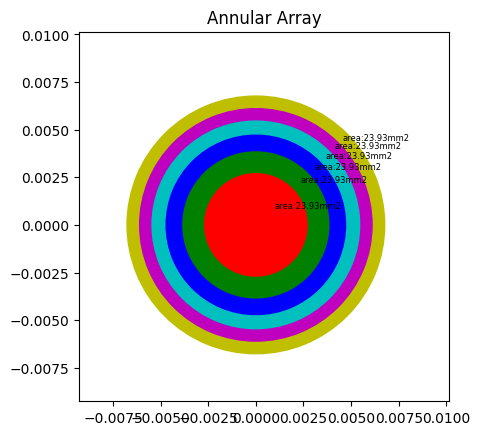

F(m):0.010 r(m):0.010782 Max=6.060e+06
F(m):0.011 r(m):0.011562 Max=8.942e+06
F(m):0.012 r(m):0.012402 Max=1.147e+07
F(m):0.013 r(m):0.013302 Max=1.348e+07
F(m):0.014 r(m):0.014263 Max=1.501e+07
F(m):0.015 r(m):0.015163 Max=1.613e+07
F(m):0.016 r(m):0.016124 Max=1.692e+07
F(m):0.017 r(m):0.017024 Max=1.745e+07
F(m):0.018 r(m):0.017984 Max=1.777e+07
F(m):0.019 r(m):0.018885 Max=1.794e+07


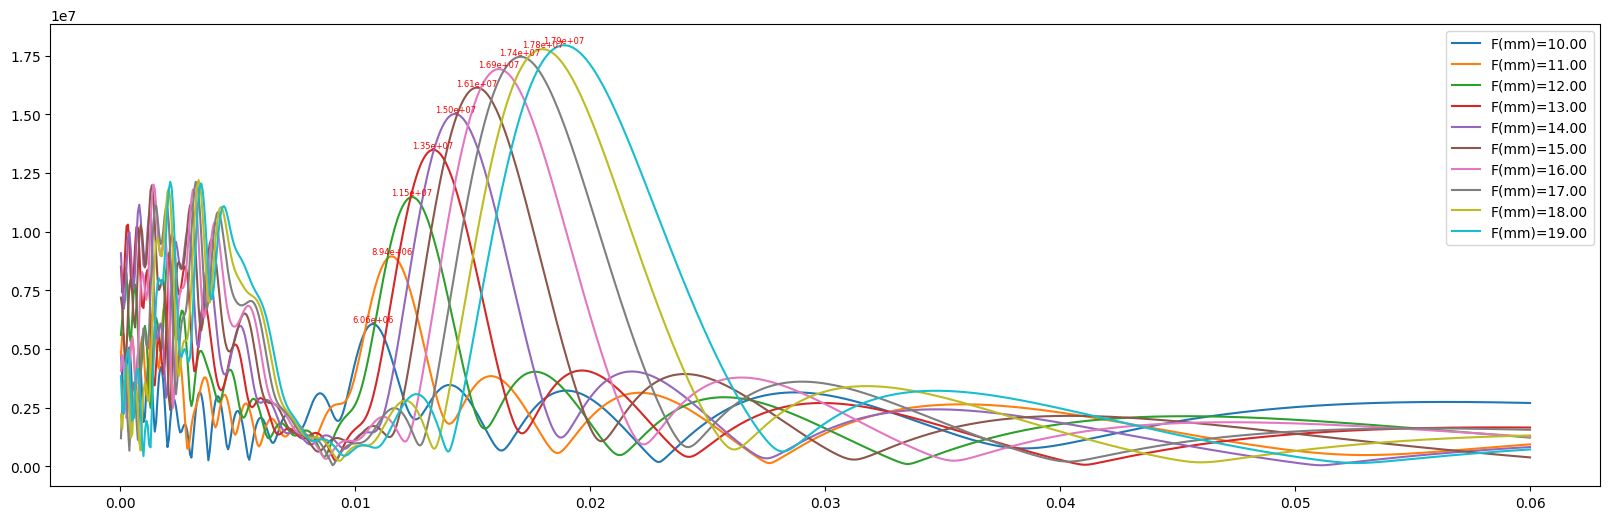

In [46]:
# 近场声压计算
# 计算相位延迟
F = 20e-3
R_max = 6.76e-3
m = 6
delta_d = 0.7 * lambda_

r_values = np.linspace(0.1*lambda_, F * 3,1000)  # 不同的距离 r
pressure_amplitudes = []

a1_list = np.zeros(m)
a2_list = np.zeros(m)

# 调用函数计算圆环内外径
a1_list, a2_list = calculate_annular_radii(R_max, m, delta_d)
# 调用函数绘制圆环阵列
plot_annular_array(a1_list, a2_list, colors)
# 计算单个圆环的声压
# 定义声压公式，考虑分母为 0 的情况

plt.figure(figsize=(20, 6))
pressure_amplitudes = []
pressure_amplitude_max = []
F_list = np.arange(10e-3,20e-3,1e-3)

for f_d in F_list:
    pressure_amplitudes = []
    for r_d in r_values:
        pressure= annular_array_pressure_axis(a1_list, a2_list, m, f_d, r_d ,0)
        pressure_amplitude = np.abs(pressure)
        pressure_amplitudes.append(pressure_amplitude)
    max_value = max(pressure_amplitudes)
    index = np.argmax(pressure_amplitudes)
    print("F(m):%.3f"%f_d,"r(m):%f"%(r_values[index]),"Max={:.3e}".format(max_value))
    pressure_amplitude_max.append(max_value)
    plt.text(r_values[index], pressure_amplitudes[index], f'{max_value:.2e}', ha='center', va='bottom', color='red', fontsize=6)
    plt.plot(r_values, pressure_amplitudes,label='F(mm)={:.2f}'.format(f_d*1000))  
plt.legend()
plt.show()



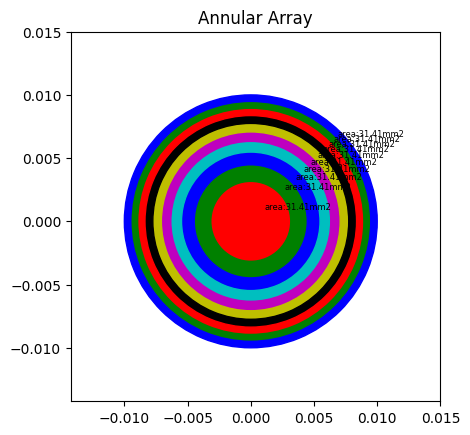

F:10.000mm, t_diff:-14.504593ns
F:11.000mm, t_diff:-12.298137ns
F:12.000mm, t_diff:-10.544169ns
F:13.000mm, t_diff:-9.130710ns
F:14.000mm, t_diff:-7.977255ns
F:15.000mm, t_diff:-7.025124ns
F:16.000mm, t_diff:-6.230931ns
F:17.000mm, t_diff:-5.562157ns
F:18.000mm, t_diff:-4.994103ns
F:19.000mm, t_diff:-4.507776ns
F:20.000mm, t_diff:-4.088401ns


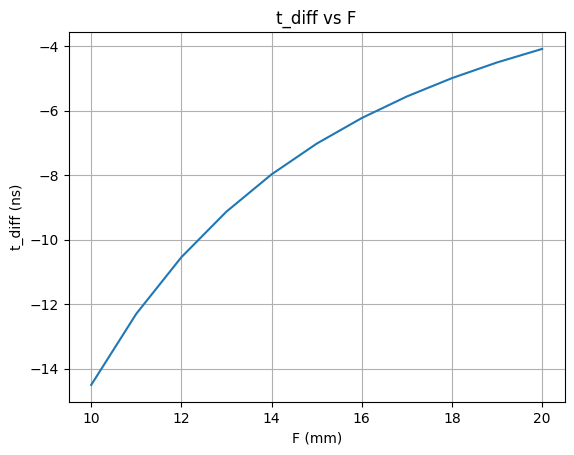

In [47]:
def min_delta_delay(a1_list,a2_list, F, delta_F):
    a0 = a2_list[0]
    a1 = a1_list[1]
    a2 = a2_list[1]
    
    #print("a0,a1,a2",a0,a1,a2)
    R0_avg = 2/3*a0
    R1_avg = 2/3*(a2**3 - a1**3)/(a2**2-a1**2)
    #print("R0_avg,R1_avg",R0_avg,R1_avg)
    
    t_delay = (np.sqrt(R1_avg**2 + F**2) - np.sqrt(R0_avg**2 + F**2))/c
    t_delta_delay = (np.sqrt(R1_avg**2 + (F+delta_F)**2) - np.sqrt(R0_avg**2 + (F+delta_F)**2))/c
    
    t_diff = t_delta_delay - t_delay
    #print("t_delay,t_delta_delay,t_diff",t_delay*1e9,t_delta_delay*1e9,t_diff*1e9)     
    return t_diff

R_max = 10e-3
m = 10
delta_d = 0.6 * lambda_

a1_list = np.zeros(m,dtype=float)
a2_list = np.zeros(m,dtype=float)

# 调用函数计算圆环内外径
a1_list, a2_list = calculate_annular_radii(R_max, m, delta_d)
# 调用函数绘制圆环阵列
plot_annular_array(a1_list, a2_list, colors)
F_list = np.arange(10e-3, 21e-3, 1e-3)
delta_F = 0.5e-3

dif = []
for F_d in F_list:
    t_diff = min_delta_delay(a1_list,a2_list, F_d, delta_F)
    dif.append(t_diff*1e9)
    print(f"F:{F_d*1e3:.3f}mm, t_diff:{t_diff*1e9:f}ns")   
    
plt.xlabel('F (mm)')
plt.ylabel('t_diff (ns)')
plt.title('t_diff vs F')
plt.grid(True)
plt.plot(F_list*1e3, dif) 


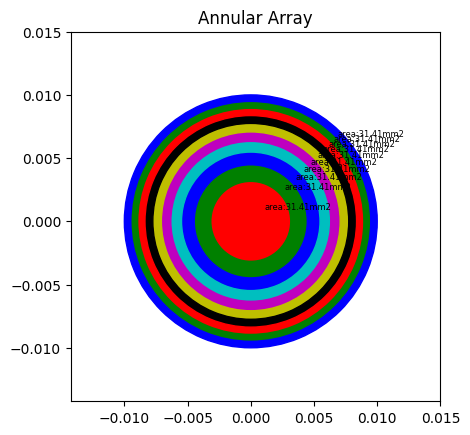

/tmp/ipykernel_68470/702000504.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


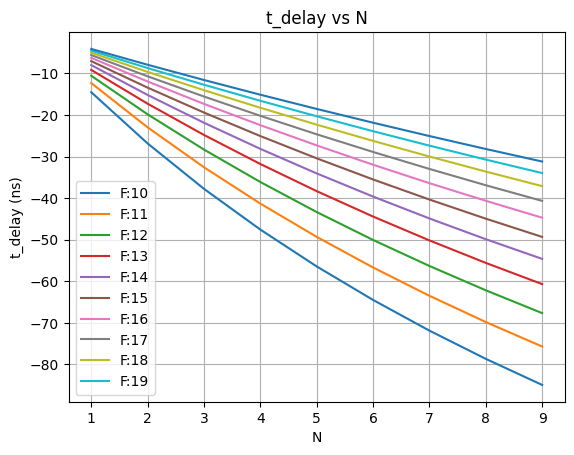

In [48]:
R_max = 10e-3
m = 10
delta_d = 0.6 * lambda_

a1_list = np.zeros(m,dtype=float)
a2_list = np.zeros(m,dtype=float)

# 调用函数计算圆环内外径
a1_list, a2_list = calculate_annular_radii(R_max, m, delta_d)
# 调用函数绘制圆环阵列
plot_annular_array(a1_list, a2_list, colors)
F_list = np.arange(10e-3, 21e-3, 1e-3)
dif = []

def annular_delta_delay(a1_list,a2_list, F, m):
    a0 = a2_list[0]
    R0_avg = 2/3*a0

    for i in np.arange(1,m):
            
        a1 = a1_list[i]
        a2 = a2_list[i]
        
        Rm_avg = 2/3*(a2**3 - a1**3)/(a2**2-a1**2)
        #t_delay = (np.sqrt(Rm_avg**2 + F**2) - np.sqrt(R0_avg**2 + F**2))/c
        #dif.append(t_delay*1e9)
        
        t_delay = (np.sqrt(Rm_avg**2 + F**2) - np.sqrt(R0_avg**2 + F**2))/c
        t_delta_delay = (np.sqrt(Rm_avg**2 + (F+delta_F)**2) - np.sqrt(R0_avg**2 + (F+delta_F)**2))/c
    
        t_diff = t_delta_delay - t_delay
        dif.append(t_diff*1e9)
        #print("t_delay: ", t_delay*1e9)
    plt.xlabel('N')
    plt.ylabel('t_delay (ns)')
    plt.title('t_delay vs N')
    plt.legend()
    plt.grid(True)         
    plt.plot(np.arange(1,m), dif,label='F:{:.0f}'.format(F*1e3)) 

for F_d in F_list:
    dif = []
    annular_delta_delay(a1_list,a2_list, F_d,m)

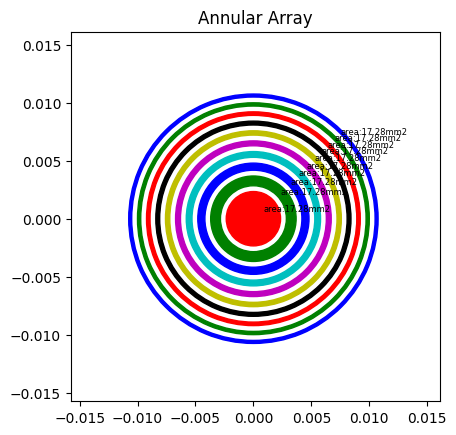

          0         1         2         3         4         5         6  \
0  0.000000  2.845208  4.187168  5.299206  6.294962  7.217629  8.089082   
1  2.345208  3.687168  4.799206  5.794962  6.717629  7.589082  8.422188   

          7          8          9  
0  8.922188   9.725261  10.504034  
1  9.225261  10.004034  10.762655  


In [59]:
# 近场声压计算
# 计算相位延迟
F = 20e-3
R_max = 10e-3
m = 10
n = 0.5e-3/lambda_
delta_d = n * lambda_

r_values = np.linspace(0.1*lambda_, F * 3,1000)  # 不同的距离 r
pressure_amplitudes = []

a1_list = np.zeros(m)
a2_list = np.zeros(m)

# 调用函数计算圆环内外径
a1_list, a2_list = calculate_annular_radii(R_max, m, n)

# 调用函数绘制圆环阵列
plot_annular_array(a1_list, a2_list, colors)
a_list = np.stack((a1_list, a2_list),axis=0)
df_a = pd.DataFrame(a_list)
print(df_a*1e3)

In [60]:
df_a*1e3

,0,1,2,3,4,5,6,7,8,9
0,0.000000,2.845208,4.187168,5.299206,6.294962,7.217629,8.089082,8.922188,9.725261,10.504034
1,2.345208,3.687168,4.799206,5.794962,6.717629,7.589082,8.422188,9.225261,10.004034,10.762655


F(mm):10.000
N: 0, r(mm):14.563 Max=3.000e+06 r(mm):7.120 Min=3.228e+04
N: 1, r(mm):14.263 Max=3.000e+06 r(mm):6.580 Min=2.864e+04
N: 2, r(mm):13.963 Max=3.000e+06 r(mm):5.800 Min=9.239e+03
N: 3, r(mm):13.603 Max=3.000e+06 r(mm):4.779 Min=1.229e+04
N: 4, r(mm):13.122 Max=3.000e+06 r(mm):3.399 Min=1.008e+04
N: 5, r(mm):12.642 Max=3.000e+06 r(mm):0.038 Min=0.000e+00
N: 6, r(mm):12.102 Max=3.000e+06 r(mm):0.038 Min=0.000e+00
N: 7, r(mm):11.502 Max=3.000e+06 r(mm):0.038 Min=0.000e+00
N: 8, r(mm):10.842 Max=3.000e+06 r(mm):0.038 Min=0.000e+00
N: 9, r(mm):10.121 Max=3.000e+06 r(mm):0.038 Min=0.000e+00


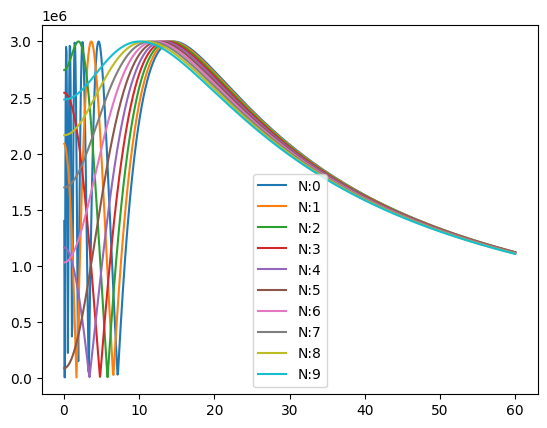

In [ ]:
pressure_amplitudes = []
pressure_amplitude_max = []

F_list = np.linspace(10e-3,21e-3,1)

for i in range(len(F_list)):
    pressure_amplitudes = []
    f_d = F_list[i]
    print("F(mm):%.3f"%(f_d*1e3))
    for j in range(m):
        for r in r_values:
            pressure = annular_array_pressure_axis_delay(a1_list, a2_list, m, j, f_d, r ,0,0)
            pressure_amplitude = np.abs(pressure)
            pressure_amplitudes.append(pressure_amplitude)

        # 使用 find_peaks 函数寻找极大值
        peaks, _ = find_peaks(pressure_amplitudes)
        peak_values = [pressure_amplitudes[peak] for peak in peaks]

        # 使用 find_peaks 函数寻找波谷（对数据取负）
        valleys, _ = find_peaks(-np.array(pressure_amplitudes))
        valley_values = [pressure_amplitudes[valley] for valley in valleys]

        if peaks.size > 0:
            max_value = peak_values[-1]
            index_max = peaks[-1]
        else:
            print(f"Warning: No peaks found for N: {j}")
            max_value = 0
            index_max = 0

        if valleys.size > 0:
            min_value = valley_values[-1]
            index_min = valleys[-1]
        else:
            print(f"Warning: No valleys found for N: {j}")
            min_value = 0
            index_min = 0
        # print("F(mm):%.3f"%(f_d*1e3))
        print("N: %d, r(mm):%.3f"%(j, r_values[index_max]*1e3), "Max={:.3e}".format(max_value), "r(mm):%.3f"%(r_values[index_min]*1e3), "Min={:.3e}".format(min_value))

        # pressure_amplitude_max.append(max_value)
        # plt.text(r_values[index], pressure_amplitudes[index], f'{max_value:.2e}', ha='center', va='bottom', color='red', fontsize=6)
        plt.plot(r_values*1e3, pressure_amplitudes,label='N:{:.0f}'.format(j))  
        pressure_amplitudes = []
        

    plt.legend()
    plt.show()

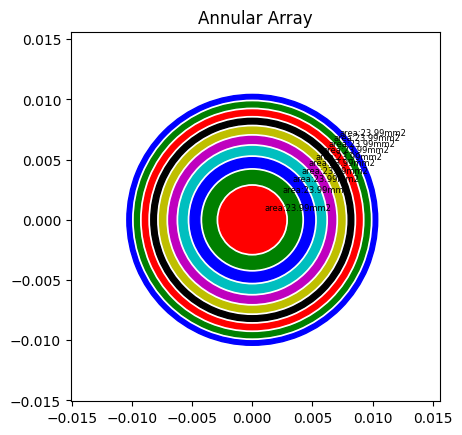

S: 2.3993913891792048e-05 Impedance: 36.1443432245439j
S: 2.399391389179206e-05 Impedance: 40.36453236580136j
S: 2.399391389179204e-05 Impedance: 40.56716528349968j
S: 2.399391389179202e-05 Impedance: 40.61759323029476j
S: 2.399391389179201e-05 Impedance: 40.6370077402242j
S: 2.3993913891792075e-05 Impedance: 40.64632894280673j
S: 2.3993913891792096e-05 Impedance: 40.65145275403419j
S: 2.3993913891792096e-05 Impedance: 40.65454065324369j
S: 2.3993913891792055e-05 Impedance: 40.65653012888747j
S: 2.399391389179201e-05 Impedance: 40.65787868901333j


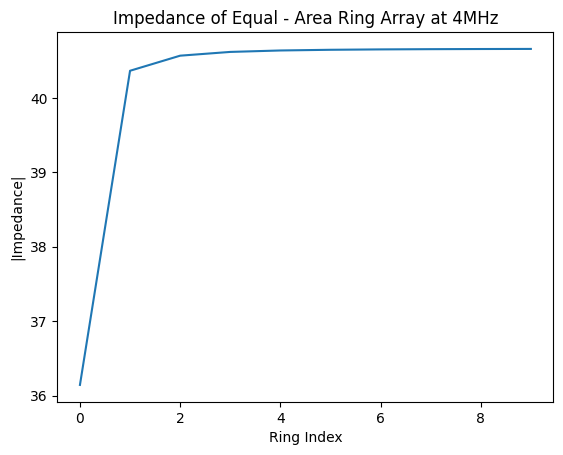

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

F = 20e-3
R_max = 10e-3
m = 10
delta_d = 0.7 * lambda_

# PZT - 3型陶瓷参数
h15 = -2.6 * 10 ** 9  # 压电应力常数
beta11s = 1.23 * 10 ** (-9)  # 恒应变下的介电隔离率
rho = 7500  # 材料密度
C55D = 2.94 * 10 ** 10  # 恒电位下的弹性刚度常数

# 计算剪切波传播速度
Ct = (C55D / rho) ** 0.5
# 根据经验公式或相关理论，假设厚度与波长相关，这里简单假设厚度为1/4波长（实际需根据具体理论模型调整）
l = lambda_ / 4  # 根据频率调整厚度

# 计算剪切波波数
kt = w / Ct

# 定义计算tau的函数
def calculate_tau(a1, a2):
    return (9 * (a1 + a2) ** 2 * (a1 ** 2 + a2 ** 2)) / (8 * (a1 ** 2 + a1 * a2 + a2 ** 2) ** 2)


# 定义计算k15t的函数
def calculate_k15t(tau):
    return h15 / np.sqrt(beta11s * C55D * tau)

# 定义计算阻抗的函数
def calculate_impedance(k15t, kt, l, omega, C0):
    return 1 / (1j * omega * C0) * (1 - (k15t ** 2) * (np.tan(kt * l / 2) / (kt * l / 2)))

impedance = np.zeros(m, dtype=complex)
a1_list = np.zeros(m)
a2_list = np.zeros(m)

# 调用函数计算圆环内外径
a1_list, a2_list = calculate_annular_radii(R_max, m, n)
# 调用函数绘制圆环阵列
plot_annular_array(a1_list, a2_list, colors)
# 计算每个圆环的阻抗
for i in range(m):
    # 计算每个圆环的面积作为振动横截面积S
    S = np.pi * (a2_list[i] ** 2 - a1_list[i] ** 2)
    # 根据公式计算C0
    C0 = S / (beta11s * l)
    tau = calculate_tau(a2_list[i], a1_list[i])
    k15t = calculate_k15t(tau)
    impedance[i] = calculate_impedance(k15t, kt, l, w, C0)
    print("S:", S, "Impedance:", impedance[i])
    
# 绘制圆环序号与阻抗模值的关系图
plt.plot(np.arange(0, m), np.abs(impedance))
plt.xlabel('Ring Index')
plt.ylabel('|Impedance|')
plt.title('Impedance of Equal - Area Ring Array at 4MHz')
plt.show()

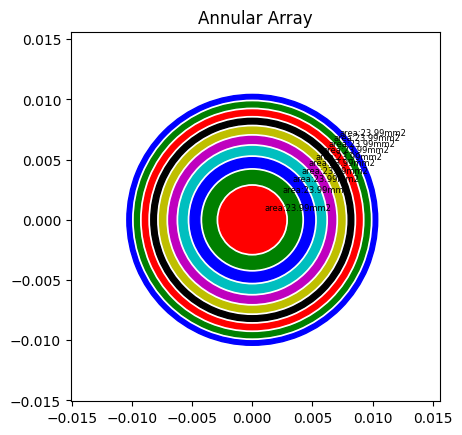

S: 2.3993913891792048e-05 Impedance: 36.1443432245439j
S: 2.399391389179206e-05 Impedance: 40.36453236580136j
S: 2.399391389179204e-05 Impedance: 40.56716528349968j
S: 2.399391389179202e-05 Impedance: 40.61759323029476j
S: 2.399391389179201e-05 Impedance: 40.6370077402242j
S: 2.3993913891792075e-05 Impedance: 40.64632894280673j
S: 2.3993913891792096e-05 Impedance: 40.65145275403419j
S: 2.3993913891792096e-05 Impedance: 40.65454065324369j
S: 2.3993913891792055e-05 Impedance: 40.65653012888747j
S: 2.399391389179201e-05 Impedance: 40.65787868901333j


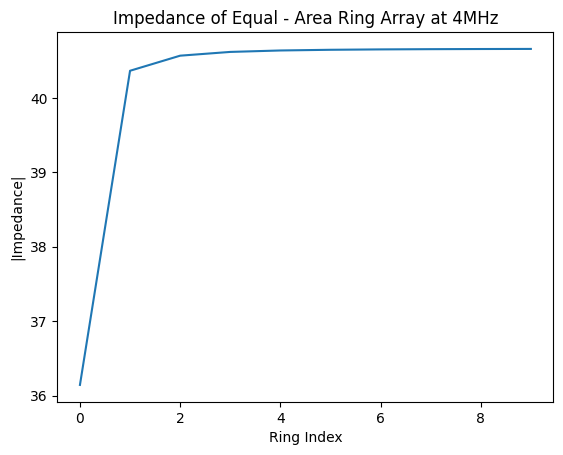

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

F = 20e-3
R_max = 10e-3
m = 10
delta_d = 0.7 * lambda_

# PZT - 3型陶瓷参数
h15 = -2.6 * 10 ** 9  # 压电应力常数
beta11s = 1.23 * 10 ** (-9)  # 恒应变下的介电隔离率
rho = 7500  # 材料密度
C55D = 2.94 * 10 ** 10  # 恒电位下的弹性刚度常数

# 计算剪切波传播速度
Ct = (C55D / rho) ** 0.5
# 根据经验公式或相关理论，假设厚度与波长相关，这里简单假设厚度为1/4波长（实际需根据具体理论模型调整）
l = lambda_ / 4  # 根据频率调整厚度

# 计算剪切波波数
kt = w / Ct

# 定义计算tau的函数
def calculate_tau(a1, a2):
    return (9 * (a1 + a2) ** 2 * (a1 ** 2 + a2 ** 2)) / (8 * (a1 ** 2 + a1 * a2 + a2 ** 2) ** 2)


# 定义计算k15t的函数
def calculate_k15t(tau):
    return h15 / np.sqrt(beta11s * C55D * tau)

# 定义计算阻抗的函数
def calculate_impedance(k15t, kt, l, omega, C0):
    return 1 / (1j * omega * C0) * (1 - (k15t ** 2) * (np.tan(kt * l / 2) / (kt * l / 2)))

impedance = np.zeros(m, dtype=complex)
a1_list = np.zeros(m)
a2_list = np.zeros(m)

# 调用函数计算圆环内外径
a1_list, a2_list = calculate_annular_radii(R_max, m, n)
# 调用函数绘制圆环阵列
plot_annular_array(a1_list, a2_list, colors)
# 计算每个圆环的阻抗
for i in range(m):
    # 计算每个圆环的面积作为振动横截面积S
    S = np.pi * (a2_list[i] ** 2 - a1_list[i] ** 2)
    # 根据公式计算C0
    C0 = S / (beta11s * l)
    tau = calculate_tau(a2_list[i], a1_list[i])
    k15t = calculate_k15t(tau)
    impedance[i] = calculate_impedance(k15t, kt, l, w, C0)
    print("S:", S, "Impedance:", impedance[i])
    
# 绘制圆环序号与阻抗模值的关系图
plt.plot(np.arange(0, m), np.abs(impedance))
plt.xlabel('Ring Index')
plt.ylabel('|Impedance|')
plt.title('Impedance of Equal - Area Ring Array at 4MHz')
plt.show()

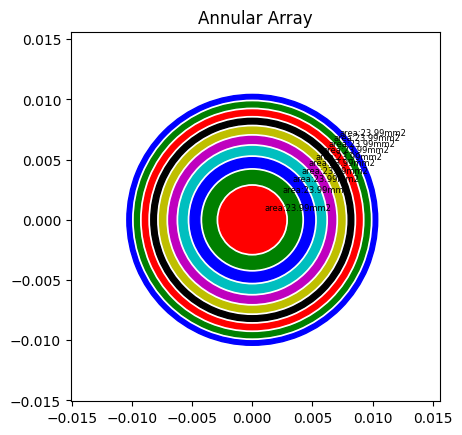

S: 2.3993913891792048e-05 Impedance: 36.1443432245439j
S: 2.399391389179206e-05 Impedance: 40.36453236580136j
S: 2.399391389179204e-05 Impedance: 40.56716528349968j
S: 2.399391389179202e-05 Impedance: 40.61759323029476j
S: 2.399391389179201e-05 Impedance: 40.6370077402242j
S: 2.3993913891792075e-05 Impedance: 40.64632894280673j
S: 2.3993913891792096e-05 Impedance: 40.65145275403419j
S: 2.3993913891792096e-05 Impedance: 40.65454065324369j
S: 2.3993913891792055e-05 Impedance: 40.65653012888747j
S: 2.399391389179201e-05 Impedance: 40.65787868901333j


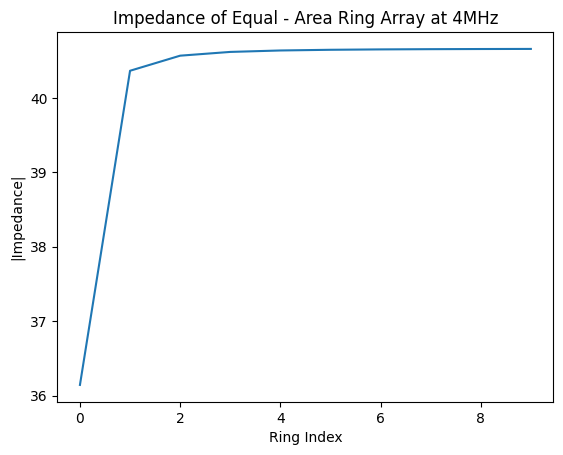

In [23]:
from mpl_toolkits.mplot3d import Axes3D

F = 20e-3
R_max = 10e-3
m = 10
delta_d = 0.7 * lambda_

# PZT - 3型陶瓷参数
h15 = -2.6 * 10 ** 9  # 压电应力常数
beta11s = 1.23 * 10 ** (-9)  # 恒应变下的介电隔离率
rho = 7500  # 材料密度
C55D = 2.94 * 10 ** 10  # 恒电位下的弹性刚度常数

# 计算剪切波传播速度
Ct = (C55D / rho) ** 0.5
# 根据经验公式或相关理论，假设厚度与波长相关，这里简单假设厚度为1/4波长（实际需根据具体理论模型调整）
l = lambda_ / 4  # 根据频率调整厚度

# 计算剪切波波数
kt = w / Ct

# 定义计算tau的函数
def calculate_tau(a1, a2):
    return (9 * (a1 + a2) ** 2 * (a1 ** 2 + a2 ** 2)) / (8 * (a1 ** 2 + a1 * a2 + a2 ** 2) ** 2)


# 定义计算k15t的函数
def calculate_k15t(tau):
    return h15 / np.sqrt(beta11s * C55D * tau)

# 定义计算阻抗的函数
def calculate_impedance(k15t, kt, l, omega, C0):
    return 1 / (1j * omega * C0) * (1 - (k15t ** 2) * (np.tan(kt * l / 2) / (kt * l / 2)))

impedance = np.zeros(m, dtype=complex)
a1_list = np.zeros(m)
a2_list = np.zeros(m)

# 调用函数计算圆环内外径
a1_list, a2_list = calculate_annular_radii(R_max, m, n)
# 调用函数绘制圆环阵列
plot_annular_array(a1_list, a2_list, colors)
# 计算每个圆环的阻抗
for i in range(m):
    # 计算每个圆环的面积作为振动横截面积S
    S = np.pi * (a2_list[i] ** 2 - a1_list[i] ** 2)
    # 根据公式计算C0
    C0 = S / (beta11s * l)
    tau = calculate_tau(a2_list[i], a1_list[i])
    k15t = calculate_k15t(tau)
    impedance[i] = calculate_impedance(k15t, kt, l, w, C0)
    print("S:", S, "Impedance:", impedance[i])
    
# 绘制圆环序号与阻抗模值的关系图
plt.plot(np.arange(0, m), np.abs(impedance))
plt.xlabel('Ring Index')
plt.ylabel('|Impedance|')
plt.title('Impedance of Equal - Area Ring Array at 4MHz')
plt.show()

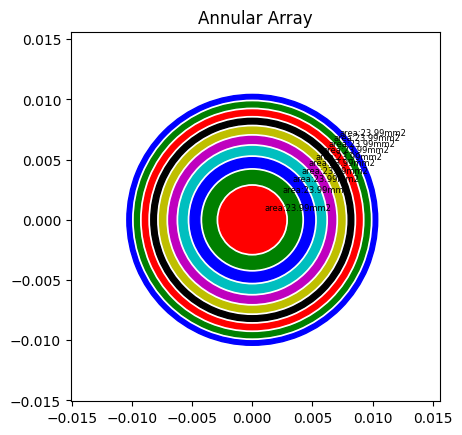

S: 2.3993913891792048e-05 Impedance: 36.1443432245439j
S: 2.399391389179206e-05 Impedance: 40.36453236580136j
S: 2.399391389179204e-05 Impedance: 40.56716528349968j
S: 2.399391389179202e-05 Impedance: 40.61759323029476j
S: 2.399391389179201e-05 Impedance: 40.6370077402242j
S: 2.3993913891792075e-05 Impedance: 40.64632894280673j
S: 2.3993913891792096e-05 Impedance: 40.65145275403419j
S: 2.3993913891792096e-05 Impedance: 40.65454065324369j
S: 2.3993913891792055e-05 Impedance: 40.65653012888747j
S: 2.399391389179201e-05 Impedance: 40.65787868901333j


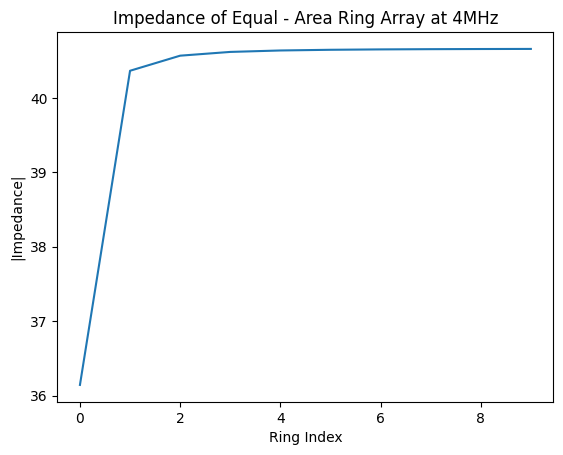

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

F = 20e-3
R_max = 10e-3
m = 10
delta_d = 0.7 * lambda_

# PZT - 3型陶瓷参数
h15 = -2.6 * 10 ** 9  # 压电应力常数
beta11s = 1.23 * 10 ** (-9)  # 恒应变下的介电隔离率
rho = 7500  # 材料密度
C55D = 2.94 * 10 ** 10  # 恒电位下的弹性刚度常数

# 计算剪切波传播速度
Ct = (C55D / rho) ** 0.5
# 根据经验公式或相关理论，假设厚度与波长相关，这里简单假设厚度为1/4波长（实际需根据具体理论模型调整）
l = lambda_ / 4  # 根据频率调整厚度

# 计算剪切波波数
kt = w / Ct

# 定义计算tau的函数
def calculate_tau(a1, a2):
    return (9 * (a1 + a2) ** 2 * (a1 ** 2 + a2 ** 2)) / (8 * (a1 ** 2 + a1 * a2 + a2 ** 2) ** 2)


# 定义计算k15t的函数
def calculate_k15t(tau):
    return h15 / np.sqrt(beta11s * C55D * tau)

# 定义计算阻抗的函数
def calculate_impedance(k15t, kt, l, omega, C0):
    return 1 / (1j * omega * C0) * (1 - (k15t ** 2) * (np.tan(kt * l / 2) / (kt * l / 2)))

impedance = np.zeros(m, dtype=complex)
a1_list = np.zeros(m)
a2_list = np.zeros(m)

# 调用函数计算圆环内外径
a1_list, a2_list = calculate_annular_radii(R_max, m, n)
# 调用函数绘制圆环阵列
plot_annular_array(a1_list, a2_list, colors)
# 计算每个圆环的阻抗
for i in range(m):
    # 计算每个圆环的面积作为振动横截面积S
    S = np.pi * (a2_list[i] ** 2 - a1_list[i] ** 2)
    # 根据公式计算C0
    C0 = S / (beta11s * l)
    tau = calculate_tau(a2_list[i], a1_list[i])
    k15t = calculate_k15t(tau)
    impedance[i] = calculate_impedance(k15t, kt, l, w, C0)
    print("S:", S, "Impedance:", impedance[i])
    
# 绘制圆环序号与阻抗模值的关系图
plt.plot(np.arange(0, m), np.abs(impedance))
plt.xlabel('Ring Index')
plt.ylabel('|Impedance|')
plt.title('Impedance of Equal - Area Ring Array at 4MHz')
plt.show()